In [1]:
''' plot wind power/ accumulated energy for around HU Lee's case & add TC tracks '''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
from scipy import interpolate
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from mystats import bandpass
from values_to_colors import values_to_rgba, truncate_colormap
from convert_time import datetime_to_yearday
sys.path.insert(0, path_nhchi+'area-master')
# "area" library is from https://github.com/scisco/area
from area import area

In [2]:
''' Model Wind power data file info '''
year = '2023'
n_f = [0.8,1.2]
lonlim = np.array([-80, -40])
latlim = np.array([10, 45])
tlim = [datetime.datetime(int(year),9,4), datetime.datetime(int(year),9,21)]
tlim_str = tlim[0].strftime('%Y%m%d')+'-'+tlim[1].strftime('%Y%m%d')
xylim_str = '{:.1f}N-{:.1f}N_{:.1f}-{:.1f}'.format(latlim[0],latlim[1],lonlim[0],lonlim[1])
path_model = os.path.expanduser('~/Documents/projects/sd-ni-wp/check_model/compute_wp/')
fn_data = 'GFS-momFlux(RTOFS-grids)_RTOFS-NIUV({:.2f}f-{:.2f}f)_'.format(n_f[0],n_f[1])+tlim_str+'_'+xylim_str+'.nc'
''' Read data '''
ds_model = nc.Dataset(path_model + fn_data)
print(ds_model)
''' Read variables '''
vars_str = ['time','latitude','longitude','UFLX_AVE','VFLX_AVE','u_bp','v_bp']
for i, var_str in enumerate( vars_str ):
    str_exec = var_str + '= ds_model.variables["'+ var_str +'"][:]'
    exec(str_exec)
dtime_model = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=dt) for dt in time])
longitude_model = longitude
latitude_model = latitude
u_bp_model = u_bp
v_bp_model = v_bp
del longitude, latitude, u_bp, v_bp
ds_model.close()

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20230921, 10.0N-45.0N_-80.0--40.0
    subtitle: It took ~370 minutes to interpolate GFS momentum flux to RTOFS spatial grids.
    dimensions(sizes): time(432), longitude(500), latitude(506)
    variables(dimensions): float64 time(time), float64 longitude(longitude), float64 latitude(latitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude), float64 u_bp(time, latitude, longitude), float64 v_bp(time, latitude, longitude)
    groups: 


In [3]:
''' Load SD position & wind power data info '''
path_SD = os.getcwd()
fnpos_all = np.sort( os.listdir(path_SD) )
### retain the fnpos wanted only
fnpos = np.array([])
for file in fnpos_all:
    if ('wp_energy' in file) & ('.txt' in file):
        fnpos = np.append(fnpos, file)
print(len(fnpos),'Files have "wp_energy" & ".txt" in the',path_SD)
print(fnpos)

''' load topography data '''
path_topo = '/Users/chi/Documents/Data/Topography/GEBCO_23_Jan_2025/'
ds_topo = nc.Dataset(path_topo+'gebco_2024_n50.0_s5.0_w-98.0_e-30.0.nc')
# print(ds_topo)
lon_topo = ds_topo.variables['lon'][:]
lat_topo = ds_topo.variables['lat'][:]
elevation = ds_topo.variables['elevation'][:]
print(lon_topo.shape, lat_topo.shape, elevation.shape )
ds_topo.close()

3 Files have "wp_energy" & ".txt" in the /Users/chi/Documents/projects/sd-ni-wp/HU_LEE
['timeseries_wnd_cur_bp(0.80f-1.20f)_wp_energy_2023-SD1036_20230907-0919_600.0-sec-grid.txt'
 'timeseries_wnd_cur_bp(0.80f-1.20f)_wp_energy_2023-SD1041_20230906-0918_600.0-sec-grid.txt'
 'timeseries_wnd_cur_bp(0.80f-1.20f)_wp_energy_2023-SD1069_20230903-0915_600.0-sec-grid.txt']
(16320,) (10800,) (10800, 16320)


(1728, 13)
1296


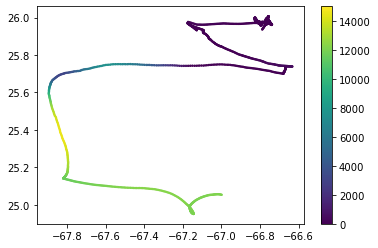

In [8]:
''' test plot accumulated energy of SD (alongtrack) '''
test = np.genfromtxt(path_SD+'/'+fnpos[0],dtype='float',delimiter=' ',skip_header=True)
print(test.shape)
dtime_this_SD = np.array( [datetime.datetime.fromtimestamp(test[i,0]) for i in range(test.shape[0])] )
itend = np.where( dtime_this_SD == datetime.datetime(int(year),9,16))[0][0]
print(itend)
plt.scatter(test[:itend+1,1],test[:itend+1,2],s=2,c=test[:itend+1,12],vmin=0,vmax=15000)
plt.colorbar()

In [9]:
''' LOAD TC tracks data '''
path_tracks = '/Users/chi/Documents/Data/IBTrACS/'
ds_tracks = nc.Dataset(path_tracks+'IBTrACS.ALL.v04r01.nc')
# print(ds_tracks)
vars_str = ['time','usa_lat','usa_lon','usa_sshs','basin','name']#,'usa_status','usa_wind','usa_pres','usa_r34','usa_r64','storm_speed']
# time:units = "days since 1858-11-17 00:00:00" ;
for i, var_str in enumerate( vars_str ):
    if 'basin' in var_str:
        str_exec = var_str + '= ds_tracks.variables["'+ var_str +'"][:]'
        exec(str_exec)
    else:
        str_exec = var_str + '= ds_tracks.variables["'+ var_str +'"][:]'
        exec(str_exec)
    print(i, str_exec)
ds_tracks.close()

dtime_track = [[np.nan for j in range(time.shape[1])] for i in range(time.shape[0])] 
for i in range( time.shape[0] ):
    for j in range( time.shape[1] ):
        if isinstance( time[i,j],float ):
            dtime_track[i][j] = datetime.datetime(1858,11,17)+datetime.timedelta(days=time[i,j])
dtime_track = np.array(dtime_track)

0 time= ds_tracks.variables["time"][:]
1 usa_lat= ds_tracks.variables["usa_lat"][:]
2 usa_lon= ds_tracks.variables["usa_lon"][:]
3 usa_sshs= ds_tracks.variables["usa_sshs"][:]
4 basin= ds_tracks.variables["basin"][:]
5 name= ds_tracks.variables["name"][:]


GFS (432.0) time limits 2023-09-04 00:00:00 2023-09-21 23:00:00


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_33517/2940960551.py:7: RuntimeWarning: Mean of empty slice
  wp_mn_box = np.nanmean( np.nanmean(wp,axis=2), axis=1 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_33517/2940960551.py:12: UserWarning: Warning: converting a masked element to nan.
  energy_box_model[t] = np.trapz( wp_mn_box[:t+1],timestamp_model[:t+1] )


' energy input integrated over time 2D (J/m^2) --> This takes too long. Can just integrate over the period of time needed. '

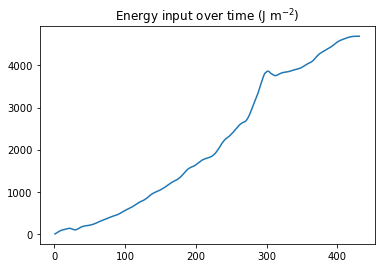

In [10]:
''' Compute wind power input (RTOFS spatial grids)'''
print('GFS ({:.1f}) time limits'.format(len(dtime_model)),dtime_model[0],dtime_model[-1])
timestamp_model = np.array([ item.timestamp() for item in dtime_model ])
''' compute wind power (W/m^2)'''
wp = np.multiply( -UFLX_AVE, u_bp_model ) + np.multiply( -VFLX_AVE, v_bp_model )
''' mean wind power of the box (for each time) (W/m^2)'''
wp_mn_box = np.nanmean( np.nanmean(wp,axis=2), axis=1 )
wp_mn_box[0] = 0
''' energy intput integrated over time 1D (J/m^2) '''
energy_box_model = np.zeros( (len(timestamp_model),) )
for t in range( len(timestamp_model) ):
    energy_box_model[t] = np.trapz( wp_mn_box[:t+1],timestamp_model[:t+1] )
''' plot time series of energy input integrated over time '''
plt.plot(energy_box_model)
plt.title('Energy input over time (J m$^{-2}$)')
''' energy input integrated over time 2D (J/m^2) --> This takes too long. Can just integrate over the period of time needed. '''
# energy_model = np.zeros( wp.shape )
# for t in range( len(timestamp_model) ):
#     for i in range( wp.shape[1] ):
#         for j in range( wp.shape[2] ):
#             energy_model[t,i,j] = np.trapz( wp[:t+1,i,j], timestamp_model[:t+1] )

In [11]:
''' test '''
dtimes_plot = [datetime.datetime(int(year),9,7)+datetime.timedelta(days=i) for i in range(10)]
for t, dtime_plot in enumerate( dtimes_plot ):
    print(t, dtime_plot)
    it_model = np.where( dtime_model == dtime_plot )[0][0]
    print(it_model)
    data = np.zeros( (wp.shape[1],wp.shape[2]) )
    for m in range( wp.shape[1] ):
        for n in range( wp.shape[2] ):
            data[m,n] = np.trapz( wp[:it_model+1,m,n], timestamp_model[:it_model+1] )
    break

0 2023-09-07 00:00:00
72


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_33517/3458526271.py:10: UserWarning: Warning: converting a masked element to nan.
  data[m,n] = np.trapz( wp[:it_model+1,m,n], timestamp_model[:it_model+1] )


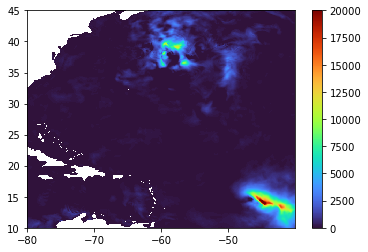

In [13]:
plt.pcolormesh(longitude_model, latitude_model, data,vmin=0,vmax=20000,cmap='turbo')
plt.colorbar()

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_33517/2226412708.py:29: UserWarning: Warning: converting a masked element to nan.
  data_acc_model[m,n] = np.trapz( wp[:it_model,m,n], timestamp_model[:it_model] )


<Figure size 432x288 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

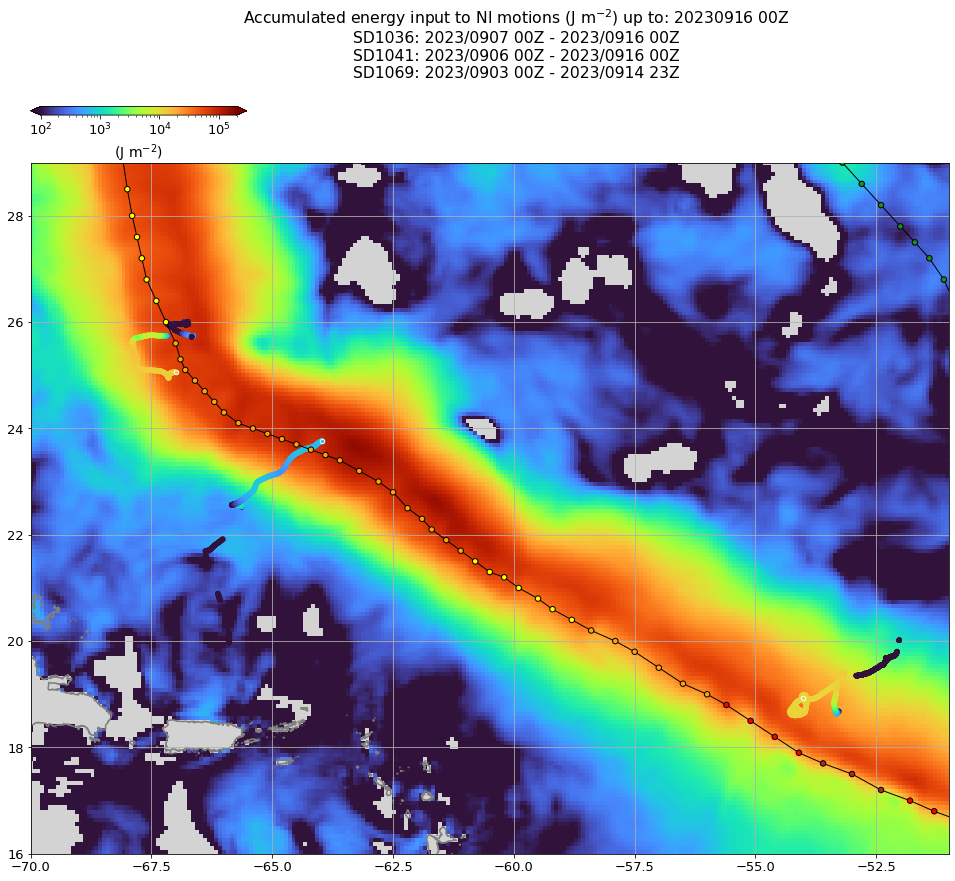

In [18]:
''' plot (1) map of accumulated energy upon given times & 
         (2) add color tracks of corresponding SD accumulated energy '''
''' given times '''
dtimes_plot = [datetime.datetime(int(year),9,7)+datetime.timedelta(days=i) for i in range(10)]
''' '''
lonlim = [-70,-51]
latlim = [16,29]
ilon_topo = np.where( (lon_topo>= lonlim[0]) & (lon_topo<= lonlim[1]) )[0]
ilat_topo = np.where( (lat_topo>= latlim[0]) & (lat_topo<= latlim[1]) )[0]
ilon_model = np.where( (longitude_model>= lonlim[0]) & (longitude_model<= lonlim[1])) [0]
ilat_model = np.where( (latitude_model>= latlim[0]) & (latitude_model<= latlim[1]) )[0]
cmap = 'turbo'
vlim_cmap = [100,200000]
sshs = np.arange(-5,6)
cols_sshs = ['rosybrown','rosybrown','rosybrown','rosybrown','navy','blue','forestgreen','yellow','orange','red','brown']
strs_sshs = ['Others','TD','TS','CAT1','CAT2','CAT3','CAT4','CAT5']
tlim_tracks = [datetime.datetime(int(year),9,1), datetime.datetime(int(year),9,21)]

''' plot 2D (map) accumulated energy up to given a given time as background '''
for t, dtime_plot in enumerate( dtimes_plot ):
    ''' integrate model wind power over time '''
    it_model = np.where( dtime_model == dtime_plot )[0]
    dtime_lim_SD = []
    if len(it_model) > 0:
        it_model = it_model[0]
        data_acc_model = np.zeros( (wp.shape[1],wp.shape[2]) )
        for m in range( wp.shape[1] ):
            for n in range( wp.shape[2] ):
                data_acc_model[m,n] = np.trapz( wp[:it_model,m,n], timestamp_model[:it_model] )
        ''' new plot for each time '''
        plt.clf()
        fig = plt.figure(figsize=(15,12))
        plt.rcParams.update({'font.size': 13})
        ax2 = fig.add_axes([0.05,0,0.85,0.8])
        ax2.set_facecolor('lightgray')
        ''' plot accumulated energy map '''
        cs = ax2.pcolormesh(longitude_model[ilon_model], latitude_model[ilat_model], data_acc_model[np.ix_(ilat_model,ilon_model)],\
                            cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=vlim_cmap[0],vmax=vlim_cmap[1]), zorder=0)
        ''' plot land boundaries '''
        ax2.contour(lon_topo[ilon_topo], lat_topo[ilat_topo], elevation[np.ix_(ilat_topo,ilon_topo)], colors='gray',levels=0,zorder=1)
        ''' plot SD tracks '''
        platf_num_SD = []
        for i, file in enumerate( fnpos ):
            dataSD = np.genfromtxt(path_SD+'/'+file,dtype='float',delimiter=' ',skip_header=True)
            ''' find the platf number of this SD '''
            id = file.find('-SD')
            platf_num_SD.append(file[id+3:id+7])
            dtime_this_SD = np.array( [datetime.datetime.fromtimestamp(dataSD[i,0]) for i in range(dataSD.shape[0])] )
            itend = np.where( dtime_this_SD == dtime_plot )[0]
            if len(itend) == 0:
                itend = len(dtime_this_SD)-1
            else:
                itend = itend[0]
            dtime_lim_SD.append([dtime_this_SD[0],dtime_this_SD[itend]])
            ''' plot SD accumulated energy track '''
            cs = ax2.scatter( dataSD[:itend,1], dataSD[:itend,2], s=20, c=dataSD[:itend,-1], \
                        cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=vlim_cmap[0],vmax=vlim_cmap[1]), zorder=2)
            ax2.scatter( dataSD[itend,1], dataSD[itend,2], s=20, c=dataSD[itend,-1], \
                        cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=vlim_cmap[0],vmax=vlim_cmap[1]), edgecolors='white',linewidths=1, zorder=3)
        ''' plot TC tracks '''
        for i in range( dtime_track.shape[0] ):
            year_this_track = str(dtime_track[i,0].year)
            if (year_this_track == year) & \
                (basin[i,0,0] == b'N') & (basin[i,0,1] == b'A'):
                edge_ok = np.ma.flatnotmasked_edges(usa_lon[i,:])
                dtime_track_ok = dtime_track[i,edge_ok[0]:edge_ok[1]+1]
                if (dtime_track_ok[0]> tlim_tracks[0]) & (dtime_track_ok[1]< tlim_tracks[1]):
                    icol = np.where( year == year_this_track )[0][0]
                    # edge_ok = np.ma.flatnotmasked_edges(usa_lon[i,:])
                    lon_ok = usa_lon[i,edge_ok[0]:edge_ok[1]+1]
                    lat_ok = usa_lat[i,edge_ok[0]:edge_ok[1]+1]
                    sshs_ok = usa_sshs[i,edge_ok[0]:edge_ok[1]+1]
                    c_sshs_ok = []
                    for j in sshs_ok+5:
                        c_sshs_ok.append(cols_sshs[j])
                    plt.plot( lon_ok, lat_ok, '-',color='k',lw=1,zorder=3)
                    sc = plt.scatter( lon_ok, lat_ok, s=30, c=c_sshs_ok, edgecolors='k', zorder=4)
        ### plot TC category icons
        # for i, str_sshs in enumerate(strs_sshs):
        #     plt.plot(-76+i*2.2, 40,'o',color=cols_sshs[i+3],ms=10)
        #     plt.text(-76+i*2.2, 40.4, str_sshs,color='k',ha='center',va='bottom')
        ### figure settings
        ax2.set_xlim(lonlim) #[-80,-40]
        ax2.set_ylim(latlim) #[10,40]
        ax2.grid()
        ### add colorbar 
        axf = fig.add_axes([0.05,0.855,0.2,0.01])
        axf = plt.colorbar(cs,orientation='horizontal',cax=axf,extend='both')
        axf.set_ticks([1e2,1e3,1e4,1e5])
        axf.set_label('(J m$^{-2}$)',fontsize=14)
        ### 
        str_out_dtime_lim_SD = []
        for i, item in enumerate(dtime_lim_SD):
            str_out_dtime_lim_SD.append('SD'+platf_num_SD[i]+': '+item[0].strftime('%Y/%m%d %HZ - ')+item[1].strftime('%Y/%m%d %HZ'))
        plt.suptitle('Accumulated energy input to NI motions (J m$^{-2}$) up to: '+dtime_plot.strftime('%Y%m%d %HZ')+'\n'+\
                     '\n'.join(str_out_dtime_lim_SD))
        ''' save figure '''
        # break
        fig.savefig('map_acc-energy_model_SD-tracks_TC-tracks_up-to-'+dtime_plot.strftime('%Y%m%d%HZ')+\
                    '_{:.1f}N-{:.1f}N_{:.1f}-{:.1f}'.format(latlim[0],latlim[1],lonlim[0],lonlim[1])+'.png', dpi=600,bbox_inches='tight')
    else:
        print('No matched model datetime data. Check if the desired datetime is out of range.')

Time period concerning wind power: [datetime.datetime(2023, 9, 8, 0, 0), datetime.datetime(2023, 9, 8, 3, 0)]


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_33517/3949516549.py:34: RuntimeWarning: Mean of empty slice
  data_model[m,n] = np.nanmean( wp[it_model,m,n],axis=0 )


Time period concerning wind power: [datetime.datetime(2023, 9, 8, 6, 0), datetime.datetime(2023, 9, 8, 9, 0)]
Time period concerning wind power: [datetime.datetime(2023, 9, 8, 12, 0), datetime.datetime(2023, 9, 8, 15, 0)]
Time period concerning wind power: [datetime.datetime(2023, 9, 12, 0, 0), datetime.datetime(2023, 9, 12, 3, 0)]
Time period concerning wind power: [datetime.datetime(2023, 9, 12, 21, 0), datetime.datetime(2023, 9, 13, 0, 0)]
Time period concerning wind power: [datetime.datetime(2023, 9, 13, 0, 0), datetime.datetime(2023, 9, 13, 3, 0)]


<Figure size 432x288 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

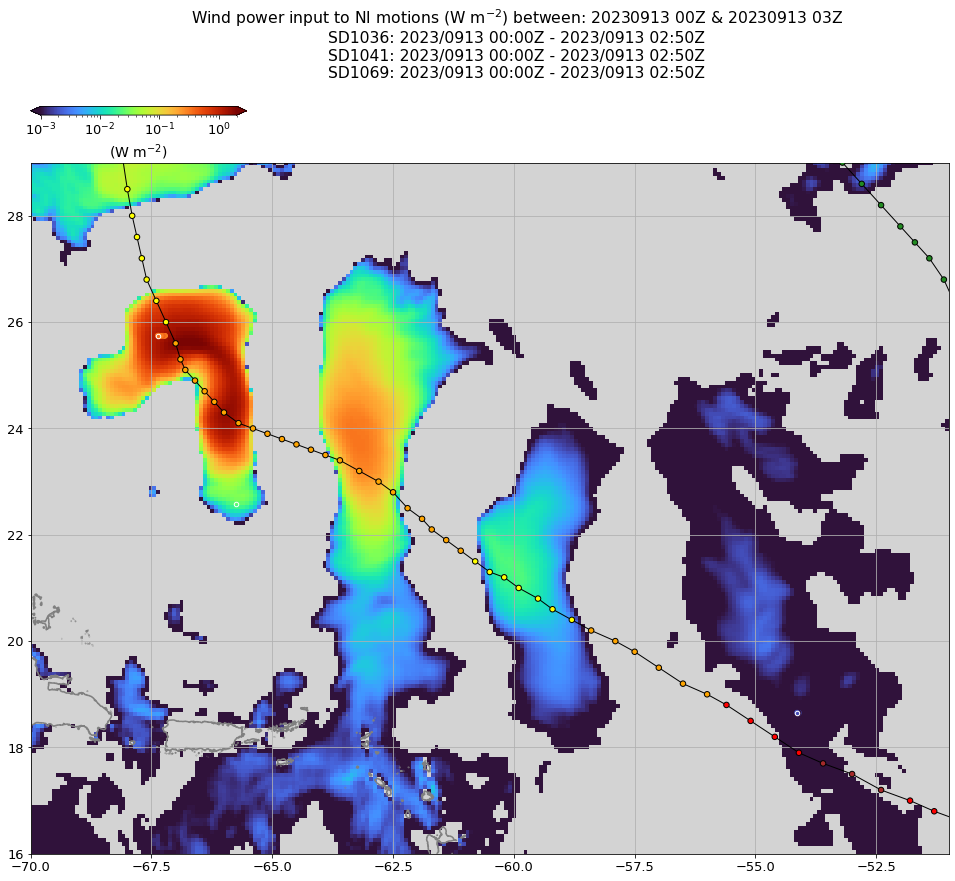

In [20]:
''' plot (1) map of averaged wind power over given time periods & 
         (2) add color tracks of corresponding SD energy '''
''' given times '''
dtimes_plot = [[datetime.datetime(int(year),9,8,0),datetime.datetime(int(year),9,8,3)],\
               [datetime.datetime(int(year),9,8,6),datetime.datetime(int(year),9,8,9)],\
                [datetime.datetime(int(year),9,8,12),datetime.datetime(int(year),9,8,15)],\
                [datetime.datetime(int(year),9,12,0),datetime.datetime(int(year),9,12,3)],\
                [datetime.datetime(int(year),9,12,21),datetime.datetime(int(year),9,13)],\
                [datetime.datetime(int(year),9,13,0),datetime.datetime(int(year),9,13,3)]]
''' '''
lonlim = [-70,-51]
latlim = [16,29]
ilon_topo = np.where( (lon_topo>= lonlim[0]) & (lon_topo<= lonlim[1]) )[0]
ilat_topo = np.where( (lat_topo>= latlim[0]) & (lat_topo<= latlim[1]) )[0]
ilon_model = np.where( (longitude_model>= lonlim[0]) & (longitude_model<= lonlim[1])) [0]
ilat_model = np.where( (latitude_model>= latlim[0]) & (latitude_model<= latlim[1]) )[0]
cmap = 'turbo'
vlim_cmap = [0.001,2]
sshs = np.arange(-5,6)
cols_sshs = ['rosybrown','rosybrown','rosybrown','rosybrown','navy','blue','forestgreen','yellow','orange','red','brown']
strs_sshs = ['Others','TD','TS','CAT1','CAT2','CAT3','CAT4','CAT5']
tlim_tracks = [datetime.datetime(int(year),9,1), datetime.datetime(int(year),9,21)]

''' plot 2D (map) accumulated energy up to given a given time as background '''
for t, dtime_plot in enumerate( dtimes_plot ):
    ''' integrate model wind power over time '''
    print('Time period concerning wind power:',dtime_plot)
    it_model = np.where( (dtime_model>= dtime_plot[0]) & (dtime_model< dtime_plot[1]) )[0]
    dtime_lim_SD = []
    if len(it_model) > 0:
        data_model = np.zeros( (wp.shape[1],wp.shape[2]) )
        for m in range( wp.shape[1] ):
            for n in range( wp.shape[2] ):
                data_model[m,n] = np.nanmean( wp[it_model,m,n],axis=0 )
        ''' new plot for each time '''
        plt.clf()
        fig = plt.figure(figsize=(15,12))
        plt.rcParams.update({'font.size': 13})
        ax2 = fig.add_axes([0.05,0,0.85,0.8])
        ax2.set_facecolor('lightgray')
        ''' plot accumulated energy map '''
        cs = ax2.pcolormesh(longitude_model[ilon_model], latitude_model[ilat_model], data_model[np.ix_(ilat_model,ilon_model)],\
                            cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=vlim_cmap[0],vmax=vlim_cmap[1]), zorder=0)
        ''' plot land boundaries '''
        ax2.contour(lon_topo[ilon_topo], lat_topo[ilat_topo], elevation[np.ix_(ilat_topo,ilon_topo)], colors='gray',levels=0,zorder=1)
        ''' plot SD tracks '''
        platf_num_SD = []
        for i, file in enumerate( fnpos ):
            dataSD = np.genfromtxt(path_SD+'/'+file,dtype='float',delimiter=' ',skip_header=True)
            ''' find the platf number of this SD '''
            id = file.find('-SD')
            platf_num_SD.append(file[id+3:id+7])
            dtime_this_SD = np.array( [datetime.datetime.fromtimestamp(dataSD[i,0]) for i in range(dataSD.shape[0])] )
            itSD = np.where( (dtime_this_SD>= dtime_plot[0]) & (dtime_this_SD< dtime_plot[1]) )[0]
            if len(itSD) == 0:
                print('No SD-'+platf_num_SD[-1],' data for',dtime_plot[0],'-',dtime_plot[1])
                dtime_lim_SD.append([0,0])
            else:
                dtime_lim_SD.append([dtime_this_SD[itSD][0],dtime_this_SD[itSD][-1]])
                ''' plot SD wind power track '''
                cs = ax2.scatter( dataSD[itSD,1], dataSD[itSD,2], s=20, c=dataSD[itSD,-2], \
                            cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=vlim_cmap[0],vmax=vlim_cmap[1]), zorder=2)
                ax2.scatter( dataSD[itSD,1][-1], dataSD[itSD,2][-1], s=20, c=dataSD[itSD,-2][-1], \
                            cmap=cmap, norm=matplotlib.colors.LogNorm(vmin=vlim_cmap[0],vmax=vlim_cmap[1]), edgecolors='white',linewidths=1, zorder=3)
        ''' plot TC tracks '''
        for i in range( dtime_track.shape[0] ):
            year_this_track = str(dtime_track[i,0].year)
            if (year_this_track == year) & \
                (basin[i,0,0] == b'N') & (basin[i,0,1] == b'A'):
                edge_ok = np.ma.flatnotmasked_edges(usa_lon[i,:])
                dtime_track_ok = dtime_track[i,edge_ok[0]:edge_ok[1]+1]
                if (dtime_track_ok[0]> tlim_tracks[0]) & (dtime_track_ok[1]< tlim_tracks[1]):
                    icol = np.where( year == year_this_track )[0][0]
                    # edge_ok = np.ma.flatnotmasked_edges(usa_lon[i,:])
                    lon_ok = usa_lon[i,edge_ok[0]:edge_ok[1]+1]
                    lat_ok = usa_lat[i,edge_ok[0]:edge_ok[1]+1]
                    sshs_ok = usa_sshs[i,edge_ok[0]:edge_ok[1]+1]
                    c_sshs_ok = []
                    for j in sshs_ok+5:
                        c_sshs_ok.append(cols_sshs[j])
                    plt.plot( lon_ok, lat_ok, '-',color='k',lw=1,zorder=3)
                    sc = plt.scatter( lon_ok, lat_ok, s=30, c=c_sshs_ok, edgecolors='k', zorder=4)
        ### figure settings
        ax2.set_xlim(lonlim)
        ax2.set_ylim(latlim)
        ax2.grid()
        ### add colorbar 
        axf = fig.add_axes([0.05,0.855,0.2,0.01])
        axf = plt.colorbar(cs,orientation='horizontal',cax=axf,extend='both')
        axf.set_ticks([1e-3,1e-2,1e-1,1e0])
        axf.set_label('(W m$^{-2}$)',fontsize=14)
        ### 
        str_out_dtime_lim_SD = []
        for i, item in enumerate(dtime_lim_SD):
            if isinstance(item[0],datetime.datetime):
                str_out_dtime_lim_SD.append('SD'+platf_num_SD[i]+': '+item[0].strftime('%Y/%m%d %H:%MZ - ')+item[-1].strftime('%Y/%m%d %H:%MZ'))
        plt.suptitle('Wind power input to NI motions (W m$^{-2}$) between: '+dtime_plot[0].strftime('%Y%m%d %HZ & ')+\
                     dtime_plot[1].strftime('%Y%m%d %HZ')+'\n'+'\n'.join(str_out_dtime_lim_SD))
        ''' save figure '''
        fig.savefig('map_wp_model_SD-tracks_TC-tracks_'+dtime_plot[0].strftime('%Y%m%d%HZ-')+dtime_plot[1].strftime('%Y%m%d%HZ')+\
                    '_{:.1f}N-{:.1f}N_{:.1f}-{:.1f}'.format(latlim[0],latlim[1],lonlim[0],lonlim[1])+'.png', dpi=600,bbox_inches='tight')
        # break
    else:
        print('No matched model datetime data. Check if the desired datetime is out of range.')

time span for model bandpass currents: 2023-09-04 00:00:00 2023-09-21 23:00:00


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_33517/2227127351.py:39: RuntimeWarning: Mean of empty slice
  data_model = np.nanmean( np.sqrt( np.square(u_bp_model)+np.square(v_bp_model) )*100,axis=0 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_33517/2227127351.py:48: RuntimeWarning: All-NaN axis encountered
  data_model = np.nanmax( test,axis=0 )


<Figure size 432x288 with 0 Axes>

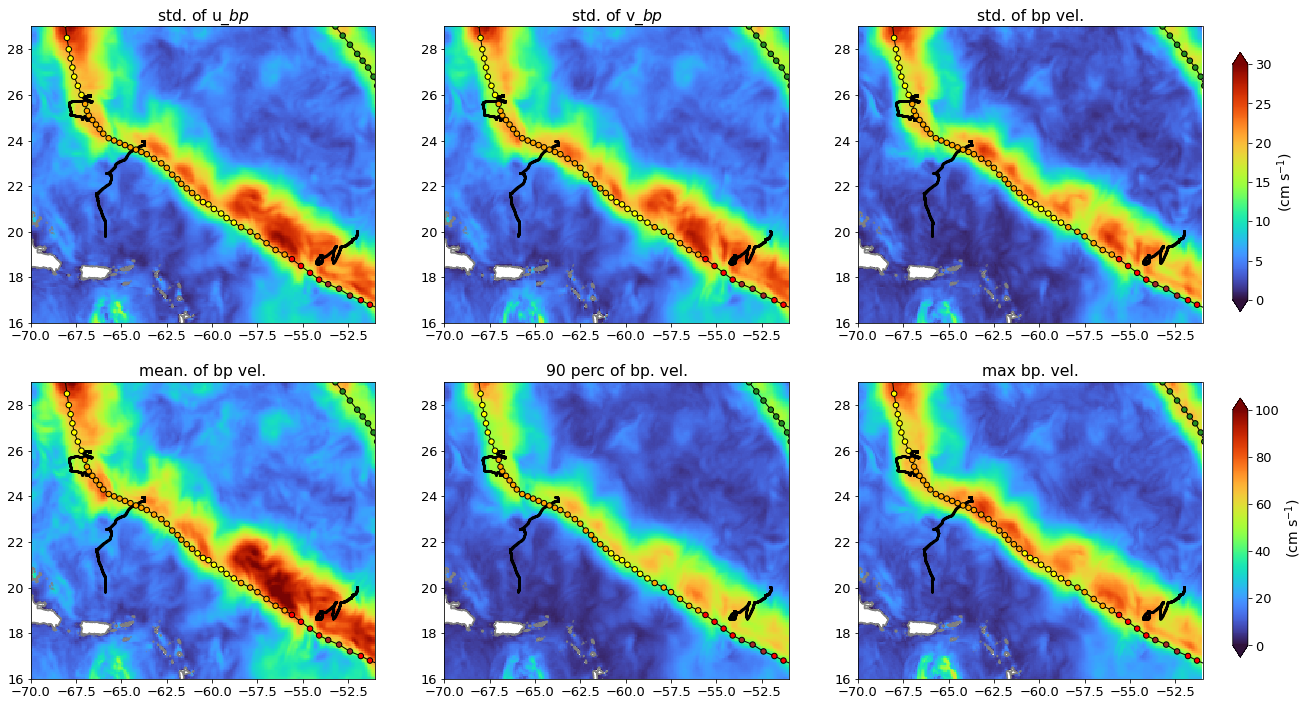

In [25]:
''' plot maps of stats of bandpass velocities '''
dtimes_plot = [dtime_model[0],dtime_model[-1]]
print('time span for model bandpass currents:',dtimes_plot[0],dtimes_plot[-1])
''' '''
lonlim = [-70,-51]
latlim = [16,29]
ilon_topo = np.where( (lon_topo>= lonlim[0]) & (lon_topo<= lonlim[1]) )[0]
ilat_topo = np.where( (lat_topo>= latlim[0]) & (lat_topo<= latlim[1]) )[0]
ilon_model = np.where( (longitude_model>= lonlim[0]) & (longitude_model<= lonlim[1])) [0]
ilat_model = np.where( (latitude_model>= latlim[0]) & (latitude_model<= latlim[1]) )[0]
cmap = 'turbo'
vlim_cmap = [0,30]
mnvlim_cmap = [0,30]
percvlim_cmap = [0,100]
sshs = np.arange(-5,6)
cols_sshs = ['rosybrown','rosybrown','rosybrown','rosybrown','navy','blue','forestgreen','yellow','orange','red','brown']
strs_sshs = ['Others','TD','TS','CAT1','CAT2','CAT3','CAT4','CAT5']
tlim_tracks = [datetime.datetime(int(year),9,1), datetime.datetime(int(year),9,21)]
perc = [90]
''' plot 2D (map) stats of bandpass currents as background '''
plt.clf()
plt.rcParams.update({'font.size': 13})
nrow = 2; ncol = 3
fig, ax = plt.subplots(nrows=nrow,ncols=ncol)
plt.gcf().set_size_inches(21, 12)
for i in range(6):
    if i == 0:
        vlim_i = vlim_cmap
        title_str = 'std. of u_${bp}$'
        data_model = np.nanstd( u_bp_model*100,axis=0 )
    if i == 1:
        title_str = 'std. of v_${bp}$'
        data_model = np.nanstd( v_bp_model*100,axis=0 )
    if i == 2:
        title_str = 'std. of bp vel.'
        data_model = np.nanstd( np.sqrt( np.square(u_bp_model)+np.square(v_bp_model) )*100,axis=0 )
    if i == 3:
        title_str = 'mean. of bp vel.'
        data_model = np.nanmean( np.sqrt( np.square(u_bp_model)+np.square(v_bp_model) )*100,axis=0 )
        vlim_i = mnvlim_cmap
    test = np.sqrt( np.square(u_bp_model)+np.square(v_bp_model) )*100
    if i == 4:
        vlim_i = percvlim_cmap
        title_str = str(perc[i-4])+' perc of bp. vel.'
        data_model = np.percentile( test,perc[i-4],axis=0 )
    if i == 5:
        title_str = 'max bp. vel.'
        data_model = np.nanmax( test,axis=0 )
    plt.subplot(nrow,ncol,i+1)
    cs = plt.pcolormesh(longitude_model[ilon_model], latitude_model[ilat_model], data_model[np.ix_(ilat_model,ilon_model)],\
                        cmap=cmap, vmin=vlim_i[0],vmax=vlim_i[1], zorder=0)
    plt.title(title_str)
    ''' add colorbar '''
    if i == 0:
        axf0 = plt.gcf().add_axes([0.92,0.55,0.01,0.3])
        axf0 = plt.colorbar(cs,orientation='vertical',cax=axf0,extend='both')
        axf0.set_ticks(np.arange(vlim_i[0],vlim_i[1]+5,5))
        axf0.set_label('(cm s$^{-1}$)',fontsize=14)
    if i == 5:
        axf5 = plt.gcf().add_axes([0.92,0.15,0.01,0.3])
        axf5 = plt.colorbar(cs,orientation='vertical',cax=axf5,extend='both')
        axf5.set_ticks(np.arange(vlim_i[0],vlim_i[1]+20,20))
        axf5.set_label('(cm s$^{-1}$)',fontsize=14)
''' plot land boundaries & TC tracks for each subplot '''
for i in range(6):
    plt.subplot(nrow,ncol,i+1)
    ''' plot land boundaries'''
    plt.contour(lon_topo[ilon_topo], lat_topo[ilat_topo], elevation[np.ix_(ilat_topo,ilon_topo)], colors='gray',levels=0,zorder=1)
    ''' plot SD tracks '''
    for f, file in enumerate( fnpos ):
        dataSD = np.genfromtxt(path_SD+'/'+file,dtype='float',delimiter=' ',skip_header=True)
        plt.scatter(dataSD[:,1],dataSD[:,2],c='k',s=1)
    ''' plot TC tracks '''
    for i in range( dtime_track.shape[0] ):
        year_this_track = str(dtime_track[i,0].year)
        if (year_this_track == year) & \
            (basin[i,0,0] == b'N') & (basin[i,0,1] == b'A'):
            edge_ok = np.ma.flatnotmasked_edges(usa_lon[i,:])
            dtime_track_ok = dtime_track[i,edge_ok[0]:edge_ok[1]+1]
            if (dtime_track_ok[0]> tlim_tracks[0]) & (dtime_track_ok[1]< tlim_tracks[1]):
                icol = np.where( year == year_this_track )[0][0]
                # edge_ok = np.ma.flatnotmasked_edges(usa_lon[i,:])
                lon_ok = usa_lon[i,edge_ok[0]:edge_ok[1]+1]
                lat_ok = usa_lat[i,edge_ok[0]:edge_ok[1]+1]
                sshs_ok = usa_sshs[i,edge_ok[0]:edge_ok[1]+1]
                c_sshs_ok = []
                for j in sshs_ok+5:
                    c_sshs_ok.append(cols_sshs[j])
                plt.plot( lon_ok, lat_ok, '-',color='k',lw=1,zorder=3)
                sc = plt.scatter( lon_ok, lat_ok, s=30, c=c_sshs_ok, edgecolors='k', zorder=4)
        ### figure settings
        plt.xlim(lonlim)
        plt.ylim(latlim)
        plt.grid()
''' save figure '''
fig.savefig('map_vel-bp({:.2f}f-{:.2f}f)_model_TC-tracks_'.format(n_f[0],n_f[1])\
            +dtime_plot[0].strftime('%Y%m%d%HZ-')+dtime_plot[1].strftime('%Y%m%d%HZ')+\
            '_{:.1f}N-{:.1f}N_{:.1f}-{:.1f}'.format(latlim[0],latlim[1],lonlim[0],lonlim[1])+'.png', dpi=600,bbox_inches='tight')

In [27]:
for f, file in enumerate( fnpos ):
    dataSD = np.genfromtxt(path_SD+'/'+file,dtype='float',delimiter=' ',skip_header=True)
    print(file)
    print(datetime.datetime.fromtimestamp(dataSD[0,0]),datetime.datetime.fromtimestamp(dataSD[-1,0]))

timeseries_wnd_cur_bp(0.80f-1.20f)_wp_energy_2023-SD1036_20230907-0919_600.0-sec-grid.txt
2023-09-07 00:00:00 2023-09-18 23:50:00
timeseries_wnd_cur_bp(0.80f-1.20f)_wp_energy_2023-SD1041_20230906-0918_600.0-sec-grid.txt
2023-09-06 00:00:00 2023-09-17 23:50:00
timeseries_wnd_cur_bp(0.80f-1.20f)_wp_energy_2023-SD1069_20230903-0915_600.0-sec-grid.txt
2023-09-03 00:00:00 2023-09-14 23:50:00


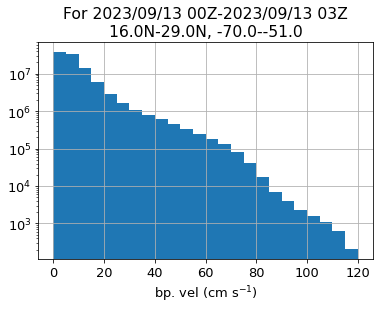

In [164]:
# print(np.nanmax(test.flatten()))
plt.hist( test.flatten(),bins=np.arange(0,125,5),log=True )
plt.grid()
plt.xlabel('bp. vel (cm s$^{-1}$)')
plt.title('For '+dtime_plot[0].strftime('%Y/%m/%d %HZ-')+dtime_plot[1].strftime('%Y/%m/%d %HZ')\
            +'\n'+'{:.1f}N-{:.1f}N, {:.1f}-{:.1f}'.format(latlim[0],latlim[1],lonlim[0],lonlim[1]))
plt.savefig('hist_vel-bp({:.2f}f-{:.2f}f)_model_'.format(n_f[0],n_f[1])\
            +dtime_plot[0].strftime('%Y%m%d%HZ-')+dtime_plot[1].strftime('%Y%m%d%HZ')+\
            '_{:.1f}N-{:.1f}N_{:.1f}-{:.1f}'.format(latlim[0],latlim[1],lonlim[0],lonlim[1])+'.png', dpi=600,bbox_inches='tight')